# PoC
Dans cette preuve de concept, je vais tenter d'évaluer plusieurs algorithmes sur un problème de classification.
Le problème en question étant: est-il possible de prédire si un malade du Covid est susceptible d'être hospitalisé en se basant sur diverses critères.
Je me base sur le dataset: https://github.com/beoutbreakprepared/nCoV2019/tree/master pour cette preuve.

In [1]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [140]:
df = spark.read.format("csv").option("header",True).load("latestdata.csv")

# Data analysis

In [3]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- city: string (nullable = true)
 |-- province: string (nullable = true)
 |-- country: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- geo_resolution: string (nullable = true)
 |-- date_onset_symptoms: string (nullable = true)
 |-- date_admission_hospital: string (nullable = true)
 |-- date_confirmation: string (nullable = true)
 |-- symptoms: string (nullable = true)
 |-- lives_in_Wuhan: string (nullable = true)
 |-- travel_history_dates: string (nullable = true)
 |-- travel_history_location: string (nullable = true)
 |-- reported_market_exposure: string (nullable = true)
 |-- additional_information: string (nullable = true)
 |-- chronic_disease_binary: string (nullable = true)
 |-- chronic_disease: string (nullable = true)
 |-- source: string (nullable = true)
 |-- sequence_available: string (nullable = true)
 |

Tout d'abord nous pouvons retirer les colonnes qui ne nous intéressent pas pour notre classification, certaines colonnes sont de toute évidence inutiles tel que admin1, admin2 etc.. De plus je retire les lignes qui ne présente pas la colonne 'outcome' qui correspond à nos labels.

In [141]:
df = df.filter(~(F.isnan('outcome')) & ~(F.col('outcome').isNull()))

In [143]:
df = df.select('age', 'sex', 'province', 'city', 'country', 'date_onset_symptoms', 'date_confirmation', 'date_death_or_discharge', 'date_admission_hospital', 'outcome')

Regardons les ratio de valeures nulles pour chaque colonnes.

In [144]:
null_ratios_by_col = df.select([F.count(F.when(~(F.col(c).isNull()), c )).alias(c) for c in df.columns]).toPandas() / 307312

<Axes: xlabel='column_name'>

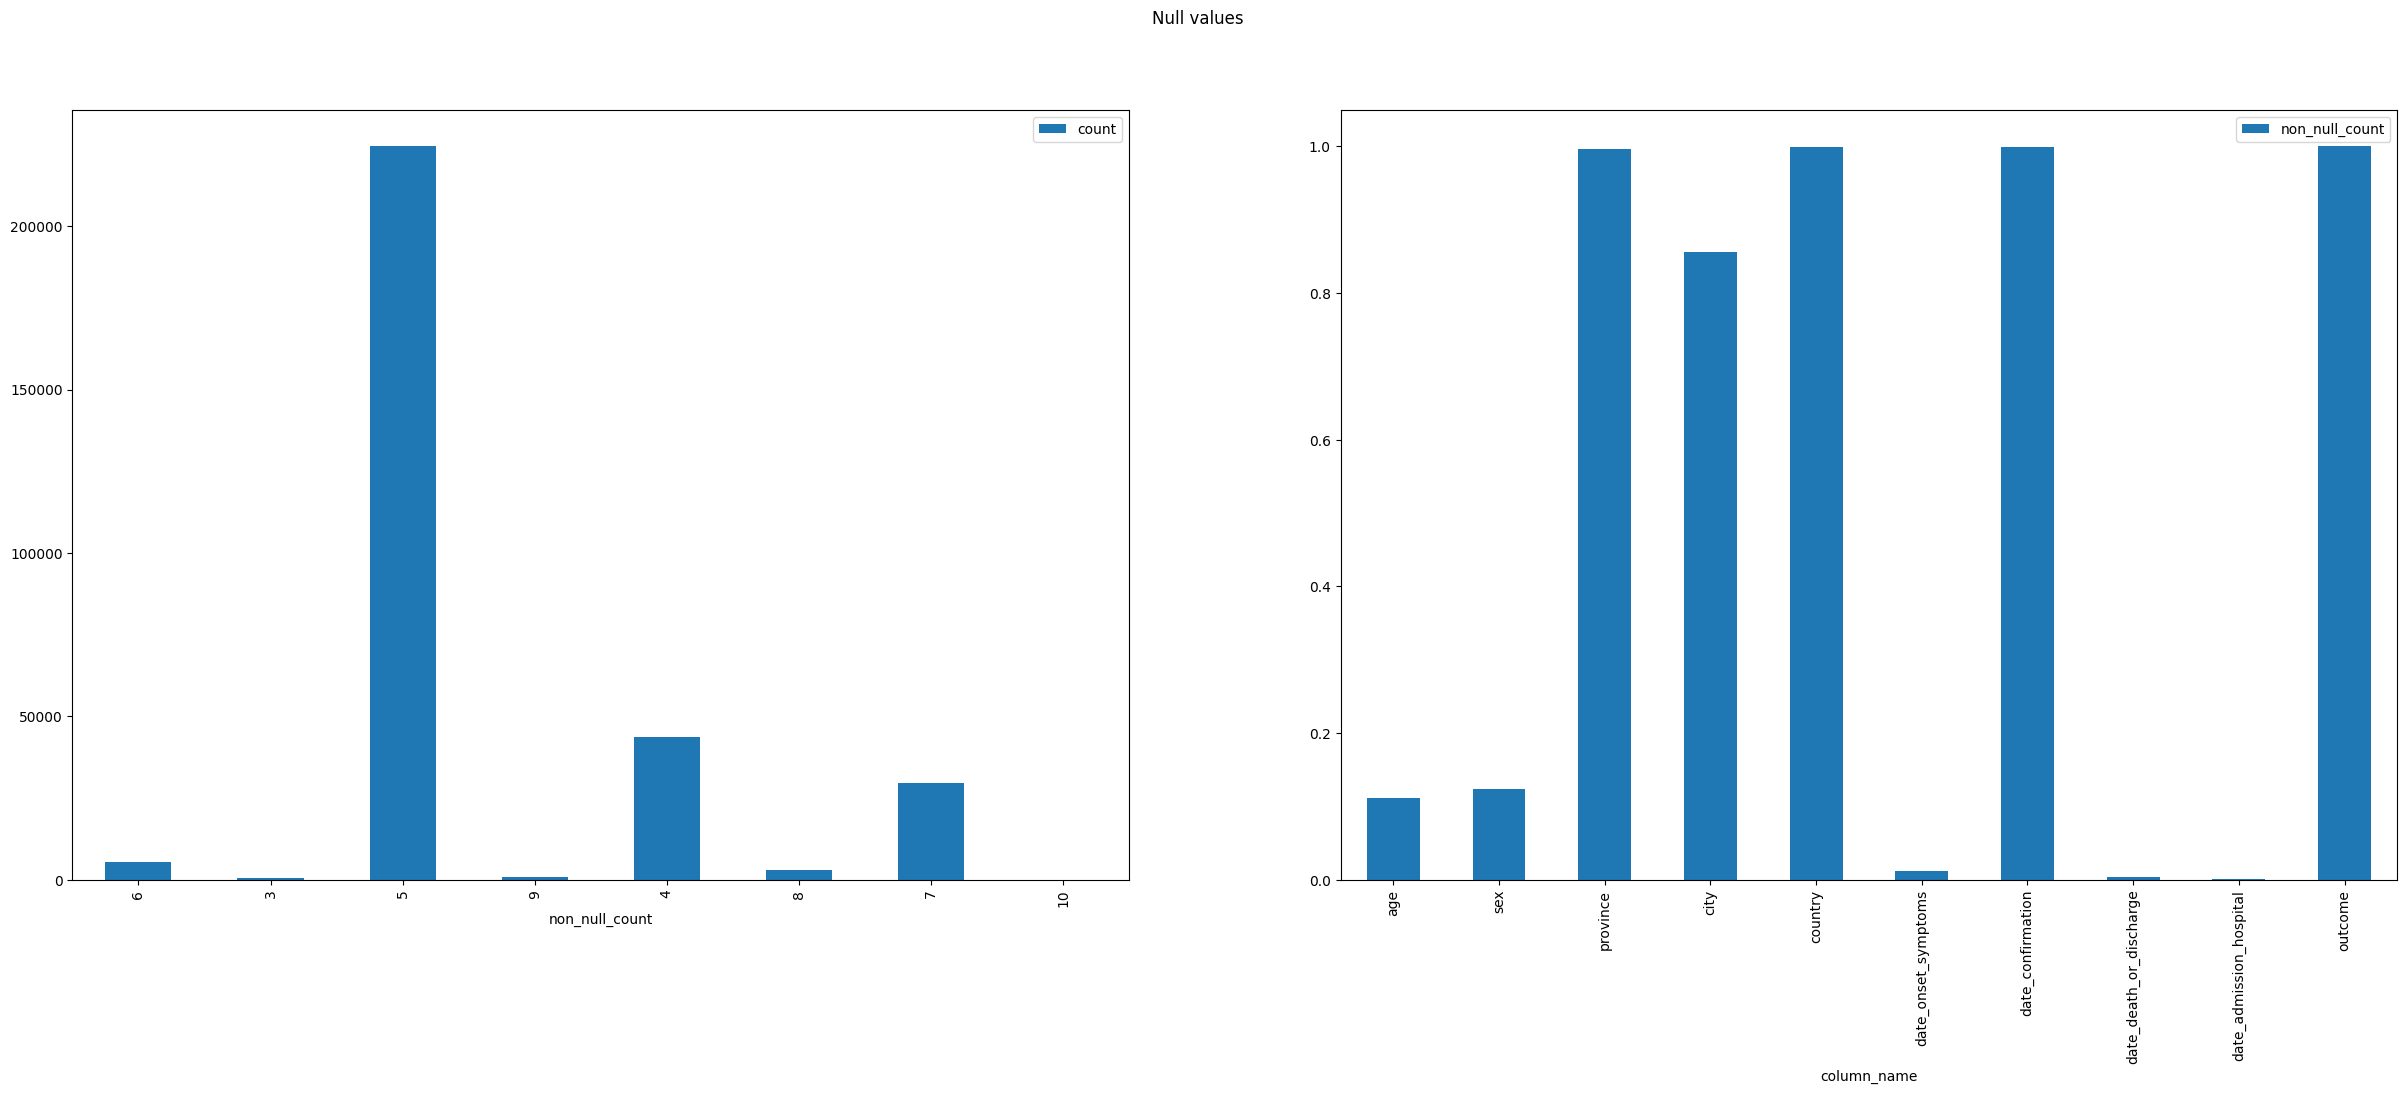

In [146]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1,2)
fig.suptitle('Null values')
fig.set_figheight(10)
fig.set_figwidth(30)

null_ratios_by_rows = df.withColumn(
    "non_null_count",
    sum(F.when(F.col(c).isNotNull(), 1).otherwise(0) for c in df.columns)
).groupBy("non_null_count").count()

null_ratios_by_col = df.select([F.count(F.when(~(F.col(c).isNull()), c )).alias(c) for c in df.columns]).toPandas() / 307312

null_ratios_by_rows.toPandas().plot(x="non_null_count", y="count", kind="bar", ax=axs[0]) 
null_ratios_by_col.melt(var_name='column_name', value_name='non_null_count').plot(x="column_name", y="non_null_count", kind="bar", ax=axs[1]) 


# Feature Engineering

On voit que certaines features sont bien renseignées, là ou d'autres sont plus clairsemées, ce qui va influer la selection des modèles.
Une partie des features intéressantes est sous forme de date, ce qui peut être plus compliqué pour nos modèles à comprendre.
Nous allons donc soustraire les dates qui nous intéresse entre elles, pour récupérer des durées.

Choix des features:
- Age
- Sex
- Country
- date_death_or_discharge - date_confirmation
    -> qui devrait représenter la durée entre la confirmation de l'infection et le 'dénouement'
- date_confirmation - date_onset_symptoms
    -> qui représente la durée entre les premiers symptomes et la confirmation de l'infection ( merci Ilyes :) )
- date du début de la pandémie covid - date_confirmation
    -> Cette variable peut aider le modèle à avoir une idée de l'écoulement du temps. J'ai choisit date_confirmation car elle est bien renseigné dans le dataset


Choix des modèles:

- LogisticRegression -> Le "go to" modèle pour tenter une classification. Il nous faudra combler les valeurs manquantes avec une technique d'imputation
- XGBoost -> modèle capable de gérer des dataset clairsemés

In [147]:
#Cast date strings to date type
df = df.withColumn('date_death_or_discharge', F.to_date(df.date_death_or_discharge, "dd.MM.yyyy"))
df = df.withColumn('date_confirmation', F.to_date(df.date_confirmation, "dd.MM.yyyy"))
df = df.withColumn('date_onset_symptoms', F.to_date(df.date_onset_symptoms, "dd.MM.yyyy"))

#Cast age to double
df = df.withColumn('age', df.age.cast('double'))

In [148]:
def calc_day_diff(df, col1, col2):
    return df.withColumn('nb_day_' + col1 + '_' + col2, F \
                .when( (F.col(col2) >= F.col(col1)) & ~(F.col(col2).isNull()) & ~(F.col(col1).isNull()), F.datediff(F.col(col2), F.col(col1))) \
                .otherwise(None))


df = calc_day_diff(df, 'date_confirmation', 'date_death_or_discharge')
df = calc_day_diff(df, 'date_onset_symptoms', 'date_confirmation')

#Calculate amount of passed day since start of covid, this can help model get a sens of passing time
df = df.withColumn('nb_day_start_to_confirm', F.datediff(df.date_confirmation, F.lit('2019-12-01')))

#Remove old columns
df = df.drop('date_onset_symptoms', 'date_confirmation', 'date_death_or_discharge')

## Je choisit comem technique d'imputation de remplacer les valeures manquantes par la moyenne des valeurs de la colonne

In [149]:
avg_age, avg_nb_day_date_confirmation_date_death_or_discharge, avg_nb_day_start_to_confirm, avg_nb_day_date_onset_symptoms_date_confirmation \
    = df.select( \
    F.avg('age'), \
    F.avg('nb_day_date_confirmation_date_death_or_discharge'),\
    F.avg('nb_day_start_to_confirm'),\
    F.avg('nb_day_date_onset_symptoms_date_confirmation') ).collect()[0]

df_imputated = df \
                .withColumn('age', F.when(df.age.isNull(), avg_age).otherwise(df.age)) \
                .withColumn('nb_day_date_confirmation_date_death_or_discharge', F.when(df.nb_day_date_confirmation_date_death_or_discharge.isNull(), avg_nb_day_date_confirmation_date_death_or_discharge).otherwise(df.nb_day_date_confirmation_date_death_or_discharge)) \
                .withColumn('nb_day_start_to_confirm', F.when(df.nb_day_start_to_confirm.isNull(), avg_nb_day_start_to_confirm).otherwise(df.nb_day_start_to_confirm)) \
                .withColumn('nb_day_date_onset_symptoms_date_confirmation', F.when(df.nb_day_date_onset_symptoms_date_confirmation.isNull(), avg_nb_day_date_onset_symptoms_date_confirmation).otherwise(df.nb_day_date_onset_symptoms_date_confirmation))


# Pré-processing


## Tout d'abord nous normalisons nos features numériques

In [150]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

def normalize_dataframe(dataframe):
    unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
    features_names = ["age", "nb_day_date_confirmation_date_death_or_discharge", "nb_day_date_onset_symptoms_date_confirmation", "nb_day_start_to_confirm"]

    for i in features_names:
        # VectorAssembler Transformation - Converting column to vector type
        assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect").setHandleInvalid("keep")
    
        # MinMaxScaler Transformation
        scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    
        # Pipeline of VectorAssembler and MinMaxScaler
        pipeline = Pipeline(stages=[assembler, scaler])
    
        # Fitting pipeline on dataframe
        dataframe = pipeline.fit(dataframe).transform(dataframe).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect").drop(i)

    return dataframe

## Puis nous utilisons le one hot encoding pour nos features catégoriques

In [151]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

def hot_encode_dataframe(dataframe):
    features_names = ["sex", "country", "city", "province"]
    indexers_encoders = []
    
    for i in features_names:
        
        indexer = StringIndexer(inputCol=i, outputCol=i+"Index").setHandleInvalid("keep")
        encoder = OneHotEncoder(dropLast=False, inputCol=i+"Index", outputCol=i+"_Vec")
        indexers_encoders.extend([indexer, encoder])
    
    pipeline = Pipeline(stages=indexers_encoders)
    return pipeline \
                .fit(dataframe) \
                .transform(dataframe) \
                .drop('sex', 'sexIndex', 'country', 'countryIndex', 'city', 'cityIndex', 'province', 'provinceIndex')

In [152]:
#sparse dataset for XGboost
df = normalize_dataframe(df)
encoded_norm_df = hot_encode_dataframe(df)

#Imputated data for logisit cregression
df_imputated = normalize_dataframe(df_imputated)
encoded_norm_imputated_df = hot_encode_dataframe(df_imputated)

## Indexation des labels

La colonne 'outcome' (nos labels) est définit dans le dataset tel que: "How the infection resolved in the patient"

Ce dataset étant une compilation de données provenant de plusieurs sources, il est compliqué de discerner les relations entre classes.
Il est par exemple compliqué de savoir si quelqu'un d'hospitalisé est par la suite décédé ou s'est rétablit

De plus, on remarque qu'il y a plusieurs classes avec une disparité dans la distribution de valeures
J'ai donc choisit comme problème de classification: Classifié chaques ligne du dataset de test, soit 'Hospitalized', soit non hospitalisé.

<Axes: xlabel='outcome'>

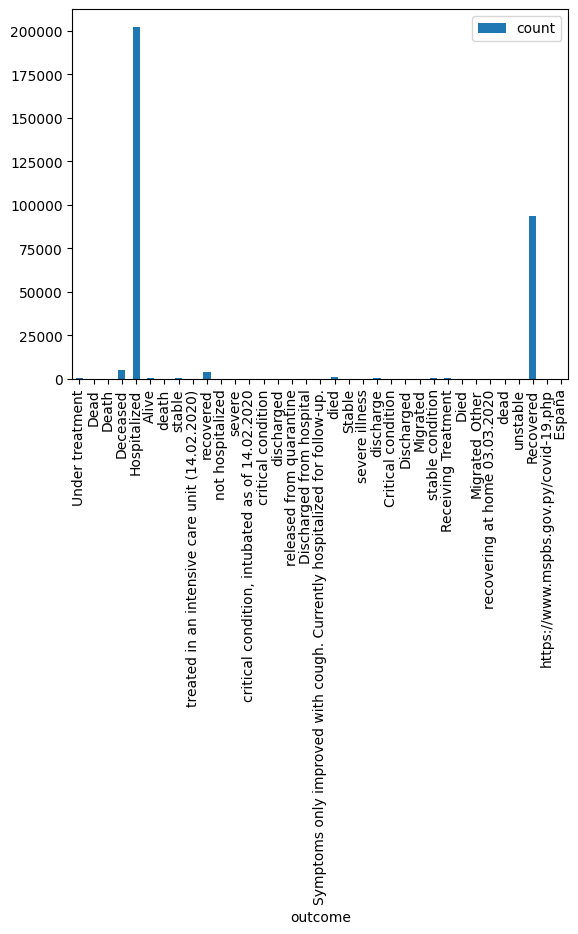

In [155]:
outcome_classes = encoded_norm_df.groupBy('outcome').count().toPandas()
outcome_classes.plot(x="outcome", y="count", kind="bar") 

In [16]:
#Indexing class 'Hospitalized' to 1 and the rest to 0
outcome_classes_death = ['Hospitalized']

encoded_norm_df = encoded_norm_df.withColumn('outcome', F.when(encoded_norm_df.outcome == 'Hospitalized', 1).otherwise(0))
encoded_norm_imputated_df = encoded_norm_imputated_df.withColumn('outcome', F.when(encoded_norm_imputated_df.outcome == 'Hospitalized', 1).otherwise(0))

## Transformation du dataset afin de correspondre au fromat attendu par les modèles spark

In [17]:
#
vec_asmbl = VectorAssembler(inputCols=['age_Scaled', \
                                        'city_Vec', \
                                        'country_Vec', \
                                        'province_Vec', \
                                        'nb_day_start_to_confirm_Scaled', \
                                        'nb_day_date_confirmation_date_death_or_discharge_Scaled', \
                                        'nb_day_date_onset_symptoms_date_confirmation_Scaled', \
                                        'sex_Vec'
                                      ], 
                           outputCol='features').setHandleInvalid("keep")

sparse_df = vec_asmbl.transform(encoded_norm_df).select('features', 'outcome')
imputated_df = vec_asmbl.transform(encoded_norm_imputated_df).select('features', 'outcome')

train_sparse_DF, test_sparse_DF = sparse_df.randomSplit([0.8, 0.2], seed=43)
train_imputated_DF, test_imputated_DF = imputated_df.randomSplit([0.8, 0.2], seed=43)

## LogisticRegression classification with the imputated dataset

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='outcome', 
                        maxIter=100, 
                        elasticNetParam=0, # Ridge regression is choosen 
                        regParam=0.003)


trained_lr = lr.fit(train_imputated_DF)
pred_lr = trained_lr.transform(test_imputated_DF)

## XGBoost with sparse dataset

In [107]:
#XGboost with the sparse dataset
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evals_result = {}

xg_boost = SparkXGBClassifier(label_col='outcome', enable_sparse_data_optim=True, missing=0.0, use_gpu=True)

trained_xg_boost = xg_boost.fit(train_sparse_DF)

pred_xg_boost = trained_xg_boost.transform(test_sparse_DF)

2024-05-20 21:43:20,483 WARNING SparkXGBClassifier: _validate_gpu_params You have enabled GPU in spark local mode. Please make sure your local node has at least 1 GPUs
2024-05-20 21:43:47,524 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': 0.0}
2024-05-20 21:44:13,198 INFO SparkXGBClassifier: _skip_stage_level_scheduling Stage-level scheduling in xgboost requires spark standalone or local-cluster mode
2024-05-20 21:44:18,854 INFO XGBoost-PySpark: _fit Finished xgboost training!


## Accuracy

In [20]:
evaluator_xg_boost = MulticlassClassificationEvaluator(labelCol='outcome', metricName="accuracy")
xg_boost_acc = evaluator_xg_boost.evaluate(pred_xg_boost)

evaluator_lr = MulticlassClassificationEvaluator(labelCol='outcome', metricName='accuracy')
lr_acc = evaluator_lr.evaluate(pred_lr)
print("Accuracy XGBoost = %.4f Accuracy Logistic Regression = %.4f" % (xg_boost_acc, lr_acc))

Accuracy XGBoost = 0.7964 Accuracy Logistic Regression = 0.7335


## Area Under Curve AUC


In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator_auc_xg_boost = BinaryClassificationEvaluator(labelCol='outcome', rawPredictionCol='prediction', metricName='areaUnderROC')
auc_xg_boost = evaluator_auc_xg_boost.evaluate(pred_xg_boost)

print("AUC XGBoost = %.4f AUC Logistic Regression = %.4f" % (auc_xg_boost, trained_lr.summary.areaUnderROC))

AUC XGBoost = 0.7247 AUC Logistic Regression = 0.7765


## Log loss


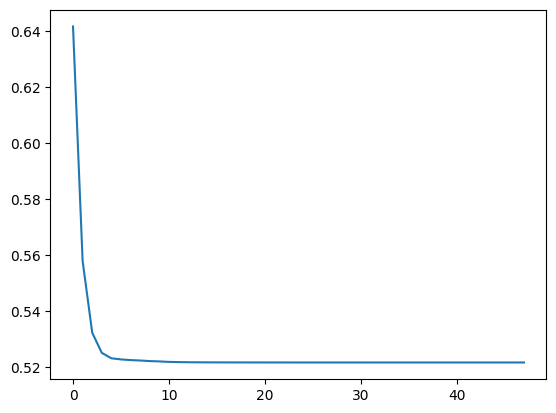

In [110]:
#TODO add logloss calc for xgbooster
plt.plot(trained_lr.summary.objectiveHistory)

## Matrices de confusion

In [125]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

preds_and_labels_xg_booster = pred_xg_boost.select(['prediction','outcome']).withColumn('label', F.col('outcome').cast(FloatType())).drop('outcome').orderBy('prediction')
confusion_matrix_xg_booster = MulticlassMetrics(preds_and_labels.rdd.map(tuple)).confusionMatrix().toArray()

preds_and_labels_lr = pred_lr.select(['prediction','outcome']).withColumn('label', F.col('outcome').cast(FloatType())).drop('outcome').orderBy('prediction')
confusion_matrix_lr = MulticlassMetrics(preds_and_labels_lr.rdd.map(tuple)).confusionMatrix().toArray()
print("Matrice de confusion Logistic regression: \n", confusion_matrix_lr)
print("Matrice de confusion XGBooster:  \n", confusion_matrix_lr)

Matrice de confusion Logistic regression: 
 [[ 7730. 13307.]
 [ 3021. 37220.]]
Matrice de confusion XGBooster:  
 [[ 7730. 13307.]
 [ 3021. 37220.]]


# Conclusions

Le dataset présenté est une compilation provenant de plusieurs sources, de données sur des personnes atteintes du covid19.
Il est fortement clairsemé et demande donc une grande partie de feature engineering / pré traitement afin de permettre un apprentissage efficace en utilisant des modèles de classification.
Avec les pré-traitements éffectués dans ce Poc, le modèle logisticregressor est capable d'atteindre 73% d'accuracy contre 80% pour XGBoost.
Cette preuve de concept montre donc une amélioration par rapport à une classification purement aléatoire de +23% et +30% respectivement.
Il reste donc un grand travail à éffectuer sur les données afin d'améliorer ces résultats.
Des pistes potentielles sont:

- Différentes techniques d'imputation pour la pipeline du logistic regressor
- Autres approches de feature engineering
- Essayer des modèles plus sophistiqués que xgboost (attention à l'overfitting de la data)
- Tester une suite d'hyper paramètres pour XGBooster et la regressions logistique